In [1]:
import torch

from ellipse_utils import (
    sample_2d_circle,
    ellipsify,
    get_ellipse_patch,
)

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 1
torch.manual_seed(seed)

radii = torch.tensor(
    [
        [0.2, 0.1],
        [0.1, 0.15],
        [0.15, 0.1],
    ],
    **tkwargs
)

angles = torch.tensor(
    [-0.2 * torch.pi, -0.2 * torch.pi, 0.05 * torch.pi, 0.15 * torch.pi], **tkwargs
)
translates = torch.tensor(
    [
        [0.2, 0.7],
        [0.55, 0.5],
        [0.68, 0.15],
    ],
    **tkwargs
)

utopia_points = torch.tensor(
    [
        [0.42, 0.95],
        [0.8, 0.6],
        [0.95, 0.22],
    ],
    **tkwargs
)

nadir = torch.zeros(1, 2, **tkwargs)

points = torch.tensor(
    [
        [0.25, 0.75],
        [0.5, 0.42],
        [0.78, 0.15],
    ],
    **tkwargs
)

# Scalarization function.
num_weights = 512
t = torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
s_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Sample the ellipses.
num_samples = 2**11
num_surface_samples = 64

base_samples = sample_2d_circle(n=num_samples, **tkwargs)
t = torch.linspace(0, 1, num_surface_samples, **tkwargs)
surface_samples = torch.column_stack(
    [torch.cos(2 * torch.pi * t), torch.sin(2 * torch.pi * t)]
)
p_samples = []
for i in range(len(radii)):
    p_samples.append(
        ellipsify(
            surface_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

samples = []
for i in range(len(radii)):
    sample = ellipsify(
        base_samples, radius=radii[i], angle=angles[i], translate=translates[i]
    )
    aug_sample = torch.row_stack([sample, p_samples[i]])
    samples.append(aug_sample)

# Compute the fronts.
base_lengths = s_fn(points).max(dim=0).values
base_front = nadir + base_lengths.unsqueeze(-1) * weights

rts_mean_lengths = s_fn(translates).max(dim=0).values
rts_mean_front = nadir + rts_mean_lengths.unsqueeze(-1) * weights

sample_lengths = torch.stack([s_fn(s) for s in samples])
str_mean_lengths = sample_lengths.mean(dim=1).max(dim=0).values
str_mean_front = nadir + str_mean_lengths.unsqueeze(-1) * weights


arrow_kwargs = {
    "arrowstyle": "<->",
    "mutation_scale": 10,
    "color": "k",
}

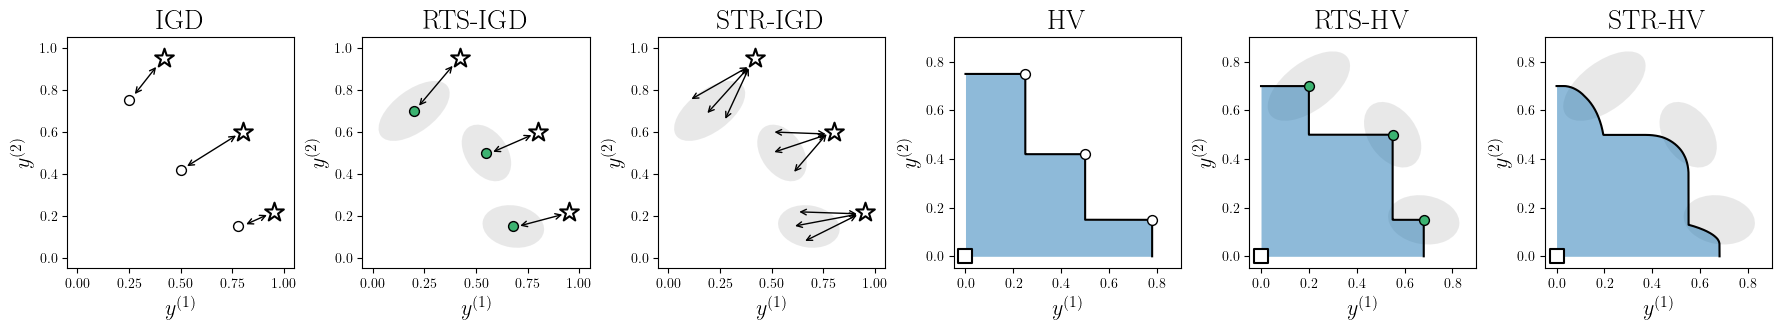

In [3]:
num_rows = 1
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 3))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35
)

for j in range(6):
    ax = plt.subplot(num_rows, num_cols, j + 1)

    if j < 3:
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
    else:
        plt.xlim(-0.05, 0.9)
        plt.ylim(-0.05, 0.9)
    plt.xlabel(r"$y^{(1)}$", fontsize=16)
    plt.ylabel(r"$y^{(2)}$", fontsize=16)

for i in range(3):
    ax = plt.subplot(num_rows, num_cols, 1 + i)

    plt.scatter(
        utopia_points[:, 0],
        utopia_points[:, 1],
        color="w",
        marker="*",
        linestyle="None",
        s=200,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

for j in [1, 4]:
    plt.subplot(num_rows, num_cols, j)
    plt.scatter(
        points[:, 0],
        points[:, 1],
        color="w",
        marker="o",
        linestyle="None",
        s=50,
        edgecolors="k",
        linewidth=1,
        zorder=5,
    )

for j in [2, 3, 5, 6]:
    ax = plt.subplot(num_rows, num_cols, j)
    for i in range(len(radii)):
        ellipse, transform = get_ellipse_patch(
            radius=radii[i],
            angle=angles[i],
            translate=translates[i],
            alpha=0.5,
            facecolor="lightgray",
        )
        ellipse.set_transform(transform + ax.transData)
        ax.add_patch(ellipse)

for i in range(3):
    plt.subplot(num_rows, num_cols, 4 + i)

    plt.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

for j in [2, 5]:
    plt.subplot(num_rows, num_cols, j)
    plt.scatter(
        translates[:, 0],
        translates[:, 1],
        color="mediumseagreen",
        marker="o",
        linestyle="None",
        s=50,
        edgecolors="k",
        linewidth=1,
        zorder=5,
    )

###################################################################
ax = plt.subplot(num_rows, num_cols, 1)
plt.title("IGD", fontsize=20)
p = points[0]
u = utopia_points[0]
arrow = mpatches.FancyArrowPatch(
    (p[0] + 0.02, p[1] + 0.02), (u[0] - 0.03, u[1] - 0.03), **arrow_kwargs
)
ax.add_patch(arrow)

p = points[1]
u = utopia_points[1]
arrow = mpatches.FancyArrowPatch(
    (p[0] + 0.02, p[1] + 0.01), (u[0] - 0.02, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)

p = points[2]
u = utopia_points[2]
arrow = mpatches.FancyArrowPatch(
    (p[0] + 0.025, p[1] + 0.005), (u[0] - 0.02, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)

###################################################################
ax = plt.subplot(num_rows, num_cols, 2)
plt.title("RTS-IGD", fontsize=20)

p = translates[0]
u = utopia_points[0]
arrow = mpatches.FancyArrowPatch(
    (p[0] + 0.015, p[1] + 0.015), (u[0] - 0.025, u[1] - 0.025), **arrow_kwargs
)
ax.add_patch(arrow)

p = translates[1]
u = utopia_points[1]
arrow = mpatches.FancyArrowPatch(
    (p[0] + 0.02, p[1] + 0.0), (u[0] - 0.02, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)

p = translates[2]
u = utopia_points[2]
arrow = mpatches.FancyArrowPatch(
    (p[0] + 0.02, p[1] + 0.00), (u[0] - 0.02, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)
###################################################################
ax = plt.subplot(num_rows, num_cols, 3)
plt.title("STR-IGD", fontsize=20)

u = utopia_points[0]
arrow = mpatches.FancyArrowPatch(
    (0.1, 0.75), (u[0] - 0.025, u[1] - 0.035), **arrow_kwargs
)
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(
    (0.18, 0.68), (u[0] - 0.025, u[1] - 0.035), **arrow_kwargs
)
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(
    (0.27, 0.65), (u[0] - 0.025, u[1] - 0.035), **arrow_kwargs
)
ax.add_patch(arrow)

u = utopia_points[1]
arrow = mpatches.FancyArrowPatch(
    (0.5, 0.6), (u[0] - 0.025, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(
    (0.50, 0.5), (u[0] - 0.025, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(
    (0.6, 0.4), (u[0] - 0.025, u[1] - 0.00), **arrow_kwargs
)
ax.add_patch(arrow)

u = utopia_points[2]
arrow = mpatches.FancyArrowPatch(
    (0.62, 0.22), (u[0] - 0.025, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(
    (0.60, 0.15), (u[0] - 0.025, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(
    (0.65, 0.075), (u[0] - 0.025, u[1] - 0.01), **arrow_kwargs
)
ax.add_patch(arrow)
###################################################################
plt.subplot(num_rows, num_cols, 4)
plt.title("HV", fontsize=20)
plt.plot(base_front[:, 0], base_front[:, 1], color="k")
plt.fill_between(
    base_front[:, 0],
    nadir[0, 0] * torch.ones_like(base_front[:, 0]),
    base_front[:, 1],
    color="tab:blue",
    alpha=0.5,
    linewidth=0,
)
###################################################################
plt.subplot(num_rows, num_cols, 5)
plt.title("RTS-HV", fontsize=20)
plt.plot(rts_mean_front[:, 0], rts_mean_front[:, 1], color="k")
plt.fill_between(
    rts_mean_front[:, 0],
    nadir[0, 0] * torch.ones_like(rts_mean_front[:, 0]),
    rts_mean_front[:, 1],
    color="tab:blue",
    alpha=0.5,
    linewidth=0,
)
###################################################################
plt.subplot(num_rows, num_cols, 6)
plt.title("STR-HV", fontsize=20)
plt.plot(str_mean_front[:, 0], str_mean_front[:, 1], color="k")
plt.fill_between(
    str_mean_front[:, 0],
    nadir[0, 0] * torch.ones_like(str_mean_front[:, 0]),
    str_mean_front[:, 1],
    color="tab:blue",
    alpha=0.5,
    linewidth=0,
)

plt.show()